__Import Libraries__

In [675]:
import pandas as pd
import numpy as np
from tabula import read_pdf
from tabulate import tabulate
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import requests
#from pandas.io.json import json_normalize

from pandas import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium
import webbrowser
from folium.plugins import MarkerCluster
pd.options.mode.chained_assignment = None  # default='warn'

__Download and Explore New York Geospatial Dataset__

In [676]:
#!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
#print('Data downloaded!')
url1 = 'https://cocl.us/new_york_dataset'
#url1='https://www.simboli.eu/download/182/'
json_data = requests.get(url1).json()
#json_data
#with open('newyork_data.json') as json_data:
    #newyork_data = json.load(json_data)
newyork_data = requests.get(url1).json()
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

__Transform New York geospatial data into a pandas dataframe__

In [677]:
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


__Scrape New York City 2010 Population Census Data; Determine Neighborhoods with high percentage of Asians__

In [678]:
df = read_pdf(r'https://www1.nyc.gov/assets/planning/download/pdf/data-maps/nyc-population/census2010/t_pl_p3a_nta.pdf',
              encoding="utf-8",
              guess=False,
              pages='all', 
              #pages = 5,
              area = (135, 54, 550, 1300),
              #columns =(94.5, 117, 139.5, 279, 297, 319.5, 351, 387, 423, 459, 495, 531, 585, 616.5) # measured by end of column
              columns = (98.5, 121, 152.5, 336, 374, 415.5, 454, 506, 542, 590, 630, 708, 780, 792.5)
                         # measured by end of column
               
             )
                        #area sequence: top,left,bottom,right
df.columns=['Borough', 'Census FIPS County Code', 'NTA_Code', 'Neighborhood', 'Total Population', 'White', 
         'Black/African American', 'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and Other Pacifc Islander', 
         'Some Other Race', 'Total', 'Hispanic Origin']
df = df[pd.notnull(df['NTA_Code'])]
df = df[df['Borough'].str.contains("Neighbor") == False]
df = df[df['Borough'].str.contains("Primarily") == False]
df.columns = df.columns.str.strip()
df.astype('str')
df['Total Population']=df['Total Population'].str.replace(',','')
df['White']=df['White'].str.replace(',','')
df['Black/African American']=df['Black/African American'].str.replace(',','')
df['American Indian and Alaska Native']=df['American Indian and Alaska Native'].str.replace(',','')
df['Asian']=df['Asian'].str.replace(',','')
df['Native Hawaiian and Other Pacifc Islander']=df['Native Hawaiian and Other Pacifc Islander'].str.replace(',','')
df['Some Other Race']=df['Some Other Race'].str.replace(',','')
df['Total']=df['Total'].str.replace(',','')
df['Hispanic Origin']=df['Hispanic Origin'].str.replace(',','')
for i in range(0, len(df.columns)):
    df.iloc[:,i] = pd.to_numeric(df.iloc[:,i], errors='ignore')
df.drop(df.loc[df['Total Population']==0].index, inplace=True)

df['Asian Population Percentage'] = ((100 * df['Asian']/df['Total Population']).round(2).astype(str) + '%')
df = df.sort_values('Asian Population Percentage', ascending=False)
df.reset_index(inplace = True, drop = True) 


new_df = pd.DataFrame(df.Neighborhood.str.split('-').tolist(), index=df.NTA_Code).stack()
new_df = new_df.reset_index([0, 'NTA_Code'])
new_df.columns = ['NTA_Code', 'Neighborhood']
df1 = df[['Borough','NTA_Code', 'Asian Population Percentage']]
new_df.head(10)
#split neighborhoods in population file to match neigborhoods in geospatial data file and Foursquare. Some accuracy may be lost

nyc_asian_df = df1.merge(new_df, left_on=['NTA_Code'], right_on = ['NTA_Code'], how='left')
nyc_asian_df = nyc_asian_df[['Borough','NTA_Code','Neighborhood', 'Asian Population Percentage']]
nyc_asian_df.head()


,Borough,NTA_Code,Neighborhood,Asian Population Percentage
0,Brooklyn,BK40,Windsor Terrace,9.89%
1,Staten Island,SI37,Stapleton,9.7%
2,Staten Island,SI37,Rosebank,9.7%
3,Brooklyn,BK25,Homecrest,9.51%
4,Manhattan,MN32,Yorkville,9.27%


__Join New York City Geospatial Data with Population Data; Drop rows without Asian Population__

In [679]:
nyc_df = neighborhoods.merge(nyc_asian_df, left_on=['Borough','Neighborhood'], right_on = ['Borough','Neighborhood'], how='left')
#drop neighborhoods without Asian Population
nyc_df = nyc_df[pd.notnull(nyc_df['Asian Population Percentage'])]
nyc_df = nyc_df.sort_values('Asian Population Percentage', ascending=False)
nyc_df.reset_index(inplace = True, drop = True) 
nyc_df.head()


,Borough,Neighborhood,Latitude,Longitude,NTA_Code,Asian Population Percentage
0,Brooklyn,Windsor Terrace,40.656946,-73.980073,BK40,9.89%
1,Staten Island,Stapleton,40.626928,-74.077902,SI37,9.7%
2,Staten Island,Rosebank,40.615305,-74.069805,SI37,9.7%
3,Brooklyn,Homecrest,40.598525,-73.959185,BK25,9.51%
4,Manhattan,Yorkville,40.775930,-73.947118,MN32,9.27%


__Drop neighborhoods that belong to Bronx and Staten Island boroughs. These have smaller Chinese populations (based on research data)__

In [680]:
nyc_df.drop(nyc_df.loc[nyc_df['Borough']=='Bronx'].index, inplace=True)
nyc_df.drop(nyc_df.loc[nyc_df['Borough']=='Staten Island'].index, inplace=True)
nyc_df.head()

,Borough,Neighborhood,Latitude,Longitude,NTA_Code,Asian Population Percentage
0,Brooklyn,Windsor Terrace,40.656946,-73.980073,BK40,9.89%
3,Brooklyn,Homecrest,40.598525,-73.959185,BK25,9.51%
4,Manhattan,Yorkville,40.775930,-73.947118,MN32,9.27%
5,Brooklyn,Flatbush,40.636326,-73.958401,BK42,9.18%
6,Brooklyn,Brooklyn Heights,40.695864,-73.993782,BK09,8.75%


__Use geopy library to get the latitude and longitude values of New York City__

In [681]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


__Define dataframes for Manhattan, Brooklyn, and Queens boroughs__

In [682]:
manhattan_data = nyc_df[nyc_df['Borough'] == 'Manhattan'].reset_index(drop=True)
brooklyn_data = nyc_df[nyc_df['Borough'] == 'Brooklyn'].reset_index(drop=True)
queens_data = nyc_df[nyc_df['Borough'] == 'Queens'].reset_index(drop=True)
manhattan_data.head()


,Borough,Neighborhood,Latitude,Longitude,NTA_Code,Asian Population Percentage
0,Manhattan,Yorkville,40.775930,-73.947118,MN32,9.27%
1,Manhattan,West Village,40.734434,-74.006180,MN23,8.15%
2,Manhattan,Chinatown,40.715618,-73.994279,MN27,63.87%
3,Manhattan,Upper West Side,40.787658,-73.977059,MN12,5.96%
4,Manhattan,Upper East Side,40.775639,-73.960508,MN40,4.99%


__Explore Manhattan Data__

In [683]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Yorkville are 40.775929849884875, -73.94711784471826.


__Define Foursquare credentials and version__

In [684]:
CLIENT_ID = 'YIOZ12CC5OTPGJCHS04O1CRDMSDI2WD4WQODQJ2NVXJYET3N' # your Foursquare ID
CLIENT_SECRET = 'KKWSFXR1BCJD4VXP03QEGNZMXYN24AUOLZ4KS52EXTD1HROK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YIOZ12CC5OTPGJCHS04O1CRDMSDI2WD4WQODQJ2NVXJYET3N
CLIENT_SECRET:KKWSFXR1BCJD4VXP03QEGNZMXYN24AUOLZ4KS52EXTD1HROK


__Get the top 200 venues from Foursquare__

In [686]:

LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 15000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=YIOZ12CC5OTPGJCHS04O1CRDMSDI2WD4WQODQJ2NVXJYET3N&client_secret=KKWSFXR1BCJD4VXP03QEGNZMXYN24AUOLZ4KS52EXTD1HROK&v=20180605&ll=40.775929849884875,-73.94711784471826&radius=15000&limit=200'

Get the request and examine results

In [687]:
results = requests.get(url).json()

__Define the get_category_type function__

In [688]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

__Clean the json and structure it into a pandas dataframe__

In [689]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Carl Schurz Park,Park,40.775118,-73.943763
1,City Swiggers,Beer Store,40.777515,-73.950820
2,Levain Bakery,Bakery,40.777354,-73.955284
3,Equinox East 92nd Street,Gym,40.782500,-73.950580
4,The Noguchi Museum,Art Museum,40.766735,-73.938445


__Create a function to repeat the same process to all the neighborhoods in Manhattan__

In [690]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url3 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url3).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## 2. Explore Manhattan Data

Write the code to run the above function on each neighborhood and create a new dataframe called manhattan_venues

In [691]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Yorkville
West Village
Chinatown
Upper West Side
Upper East Side
Carnegie Hill
Lower East Side
Civic Center
Little Italy
Midtown
Midtown South
Battery Park City
Hamilton Heights
Manhattanville
Murray Hill
Clinton
East Village
Gramercy
Morningside Heights
Turtle Bay
Stuyvesant Town
Hudson Yards
Chelsea
Lincoln Square
Lenox Hill
Roosevelt Island
Marble Hill
Inwood


Review the size of the resulting dataframe

In [692]:
print(manhattan_venues.shape)
manhattan_venues.head()

(2075, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Yorkville,40.77593,-73.947118,Bagel Bob's on York,40.776459,-73.946972,Bagel Shop
1,Yorkville,40.77593,-73.947118,Park East Wines & Spirits,40.776715,-73.946663,Liquor Store
2,Yorkville,40.77593,-73.947118,Peng's Noodle Folk,40.777258,-73.949110,Asian Restaurant
3,Yorkville,40.77593,-73.947118,EVF Performance,40.775625,-73.947402,Gym
4,Yorkville,40.77593,-73.947118,Yorkshire Wines & Spirits,40.776319,-73.949786,Wine Shop


__Join manhattan_venues to NYC population dataframe (manhattan_data) to obtain Asian population around each Foursquare venue; return dataframe of restaurants__

In [693]:
manhattan_venue_and_pop = manhattan_venues.merge(manhattan_data, left_on=['Neighborhood Latitude', 'Neighborhood Longitude', 'Neighborhood'], right_on = ['Latitude', 'Longitude', 'Neighborhood'], how='left')
manhattan_venue_and_pop = manhattan_venue_and_pop[['Neighborhood','Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category', 'Asian Population Percentage', 'Borough']]
manhattan_venue_rest=manhattan_venue_and_pop[manhattan_venue_and_pop['Venue Category'].str.contains("estaurant") | manhattan_venue_and_pop['Venue'].str.contains("estaurant") == True]
manhattan_venue_rest.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Asian Population Percentage,Borough
2,Yorkville,40.77593,-73.947118,Peng's Noodle Folk,40.777258,-73.949110,Asian Restaurant,9.27%,Manhattan
7,Yorkville,40.77593,-73.947118,Mansion Restaurant,40.775962,-73.946777,Diner,9.27%,Manhattan
13,Yorkville,40.77593,-73.947118,Nica Trattoria,40.775688,-73.950570,Italian Restaurant,9.27%,Manhattan
20,Yorkville,40.77593,-73.947118,PuTawn Local Thai Kitchen,40.774599,-73.951042,Thai Restaurant,9.27%,Manhattan
21,Yorkville,40.77593,-73.947118,Poke Restaurant,40.776508,-73.950548,Sushi Restaurant,9.27%,Manhattan


__Retain dataframe of venue category counts (manhattan restaurants)__

In [694]:
manhattan_rest_counts = manhattan_venue_rest.groupby(['Borough','Neighborhood','Asian Population Percentage', 'Venue Category']).size().reset_index(name='Restaurant Count')
manhattan_rest_counts.head()


,Borough,Neighborhood,Asian Population Percentage,Venue Category,Restaurant Count
0,Manhattan,Battery Park City,20.19%,Chinese Restaurant,1
1,Manhattan,Battery Park City,20.19%,Mediterranean Restaurant,1
2,Manhattan,Battery Park City,20.19%,Mexican Restaurant,2
3,Manhattan,Battery Park City,20.19%,Pub,1
4,Manhattan,Carnegie Hill,4.99%,American Restaurant,1


## 3. Explore Brooklyn Data

In [695]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn, NY are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brooklyn, NY are 40.6501038, -73.9495823.


Write the code to run the above function on each neighborhood and create a new dataframe called brooklyn_venues

In [696]:
bk_neighborhood_latitude = brooklyn_data.loc[0, 'Latitude'] # neighborhood latitude value
bk_neighborhood_longitude = brooklyn_data.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = brooklyn_data.loc[0, 'Neighborhood'] # neighborhood name
brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )


Windsor Terrace
Homecrest
Flatbush
Brooklyn Heights
Cobble Hill
Coney Island
Vinegar Hill
Fort Greene
Prospect Heights
Gowanus
Park Slope
Mill Basin
Bergen Beach
Georgetown
Marine Park
Clinton Hill
South Side
North Side
Greenpoint
Red Hook
Carroll Gardens
Dyker Heights
Flatlands
East New York
Bath Beach
Kensington
Ocean Parkway
Gravesend
Starrett City
Canarsie
Madison
Gerritsen Beach
Sheepshead Bay
Bay Ridge
Brighton Beach
East Williamsburg
Borough Park
City Line
Cypress Hills
Midwood
Erasmus
Prospect Lefferts Gardens
Wingate
East Flatbush
Rugby
Remsen Village
Brownsville
Ocean Hill
Williamsburg


Review the size of the brooklyn dataframe

In [697]:
print(brooklyn_venues.shape)
brooklyn_venues.head()

(1920, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Windsor Terrace,40.656946,-73.980073,Argyle Yarn Shop,40.657871,-73.982774,Arts & Crafts Store
1,Windsor Terrace,40.656946,-73.980073,Windsor Place Antiques,40.658858,-73.978674,Antique Shop
2,Windsor Terrace,40.656946,-73.980073,Terrace Books,40.659327,-73.981354,Bookstore
3,Windsor Terrace,40.656946,-73.980073,Bedawi Cafe,40.658588,-73.982020,Middle Eastern Restaurant
4,Windsor Terrace,40.656946,-73.980073,Brunswick,40.659428,-73.981330,Café


__Join brooklyn_venues to NYC population dataframe (brooklyn_data) to obtain Asian population at each Foursquare venue; return dataframe of restaurants__

In [698]:
brooklyn_venue_and_pop = brooklyn_venues.merge(brooklyn_data, left_on=['Neighborhood Latitude', 'Neighborhood Longitude', 'Neighborhood'], right_on = ['Latitude', 'Longitude', 'Neighborhood'], how='left')
brooklyn_venue_and_pop = brooklyn_venue_and_pop[['Neighborhood','Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category', 'Asian Population Percentage', 'Borough']]
brooklyn_venue_rest=brooklyn_venue_and_pop[brooklyn_venue_and_pop['Venue Category'].str.contains("estaurant") | brooklyn_venue_and_pop['Venue'].str.contains("estaurant") == True]
brooklyn_venue_rest.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Asian Population Percentage,Borough
3,Windsor Terrace,40.656946,-73.980073,Bedawi Cafe,40.658588,-73.982020,Middle Eastern Restaurant,9.89%,Brooklyn
5,Windsor Terrace,40.656946,-73.980073,Krupa Grocery,40.659957,-73.980696,American Restaurant,9.89%,Brooklyn
6,Windsor Terrace,40.656946,-73.980073,East Wind Snack Shop,40.660297,-73.980169,Chinese Restaurant,9.89%,Brooklyn
8,Windsor Terrace,40.656946,-73.980073,Sushi Yama,40.658542,-73.982054,Sushi Restaurant,9.89%,Brooklyn
14,Windsor Terrace,40.656946,-73.980073,Giovanni's Brooklyn Eats,40.660159,-73.983753,Italian Restaurant,9.89%,Brooklyn


__Retain dataframe of venue category counts (brooklyn restaurants)__

In [699]:
brooklyn_rest_counts = brooklyn_venue_rest.groupby(['Borough','Neighborhood','Asian Population Percentage', 'Venue Category']).size().reset_index(name='Restaurant Count')
brooklyn_rest_counts.head()
#brooklyn_rest_counts.dtypes

,Borough,Neighborhood,Asian Population Percentage,Venue Category,Restaurant Count
0,Brooklyn,Bath Beach,29.91%,Asian Restaurant,1
1,Brooklyn,Bath Beach,29.91%,Cantonese Restaurant,1
2,Brooklyn,Bath Beach,29.91%,Chinese Restaurant,4
3,Brooklyn,Bath Beach,29.91%,Dim Sum Restaurant,1
4,Brooklyn,Bath Beach,29.91%,Fast Food Restaurant,2


## 4. Explore Queens Data

In [700]:
address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn, NY are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brooklyn, NY are 40.7498243, -73.7976337.


Write the code to run the above function on each neighborhood and create a new dataframe called queens_venues

In [701]:
qn_neighborhood_latitude = queens_data.loc[0, 'Latitude'] # neighborhood latitude value
qn_neighborhood_longitude = queens_data.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = queens_data.loc[0, 'Neighborhood'] # neighborhood name


queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )


Middle Village
Ridgewood
Flushing
Queensboro Hill
North Corona
Elmhurst
Maspeth
Murray Hill
South Jamaica
Fresh Meadows
Utopia
Oakland Gardens
Elmhurst
Auburndale
East Elmhurst
Woodside
Bellerose
Bayside
Jamaica Hills
Briarwood
Douglaston
Little Neck
Glen Oaks
Floral Park
Rego Park
Pomonok
Hillcrest
Howard Beach
Lindenwood
Glendale
College Point
Richmond Hill
Holliswood
Jamaica Estates
Sunnyside
Hunters Point
Forest Hills
South Ozone Park
Jackson Heights
Bay Terrace
Kew Gardens Hills
Arverne
Edgemere
Hammels
Rosedale
Breezy Point
Belle Harbor
Ozone Park
Whitestone
Woodhaven
Astoria
Queens Village
Kew Gardens
Long Island City
Ravenswood
Queensbridge
Corona
Maspeth
Hollis
Steinway
Brookville
Bayswater
Far Rockaway
St. Albans
Cambria Heights
Laurelton


Review the size of the queens dataframe

In [702]:
print(queens_venues.shape)
queens_venues.head()

(1741, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Middle Village,40.716415,-73.881143,Juniper Valley Park Playground South,40.718504,-73.882652,Playground
1,Middle Village,40.716415,-73.881143,Juniper Valley Park,40.720281,-73.881258,Park
2,Middle Village,40.716415,-73.881143,Villa Erasmo,40.716761,-73.886221,Italian Restaurant
3,Middle Village,40.716415,-73.881143,Ralph's Famous Italian Ices,40.712856,-73.879132,Dessert Shop
4,Middle Village,40.716415,-73.881143,Carlo's Pizzeria,40.712853,-73.878169,Pizza Place


__Join queens_venues to NYC population dataframe (queens_data) to obtain Asian population at each Foursquare venue; return dataframe of restaurants__

In [703]:
queens_venue_and_pop = queens_venues.merge(queens_data, left_on=['Neighborhood Latitude', 'Neighborhood Longitude', 'Neighborhood'], right_on = ['Latitude', 'Longitude', 'Neighborhood'], how='left')
queens_venue_and_pop = queens_venue_and_pop[['Neighborhood','Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category', 'Asian Population Percentage', 'Borough']]
queens_venue_rest=queens_venue_and_pop[queens_venue_and_pop['Venue Category'].str.contains("estaurant") | queens_venue_and_pop['Venue'].str.contains("estaurant") == True]
queens_venue_rest.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Asian Population Percentage,Borough
2,Middle Village,40.716415,-73.881143,Villa Erasmo,40.716761,-73.886221,Italian Restaurant,8.07%,Queens
5,Middle Village,40.716415,-73.881143,Toyo,40.712611,-73.878948,Sushi Restaurant,8.07%,Queens
7,Middle Village,40.716415,-73.881143,Rico's Chicken,40.713009,-73.877336,South American Restaurant,8.07%,Queens
15,Ridgewood,40.708323,-73.901435,Taquerias Kermes,40.707899,-73.897762,Mexican Restaurant,7.69%,Queens
16,Ridgewood,40.708323,-73.901435,Joe's Restaurant,40.707452,-73.903355,Italian Restaurant,7.69%,Queens


__Retain dataframe of venue category counts (queens restaurants)__

In [704]:
queens_rest_counts = queens_venue_rest.groupby(['Borough','Neighborhood','Asian Population Percentage', 'Venue Category']).size().reset_index(name='Restaurant Count')
queens_rest_counts.head()
#queens_rest_counts.dtypes

,Borough,Neighborhood,Asian Population Percentage,Venue Category,Restaurant Count
0,Queens,Arverne,2.79%,Thai Restaurant,1
1,Queens,Astoria,16.19%,American Restaurant,1
2,Queens,Astoria,16.19%,Brazilian Restaurant,1
3,Queens,Astoria,16.19%,Café,1
4,Queens,Astoria,16.19%,Cajun / Creole Restaurant,1


## 5. Explore Restaurant Data from all three Boroughs (Manhattan, Brooklyn, and Queens)

In [705]:
#Union of manhattan_venue_rest, brooklyn_venue_rest, and queens_venue_rest dataframes
tri_boro_rest = pd.concat([manhattan_venue_rest, brooklyn_venue_rest, queens_venue_rest])
tri_boro_rest.rename(columns = {'Venue Category':'Venue_Category'}, inplace = True) 
tri_boro_rest.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category,Asian Population Percentage,Borough
2,Yorkville,40.77593,-73.947118,Peng's Noodle Folk,40.777258,-73.949110,Asian Restaurant,9.27%,Manhattan
7,Yorkville,40.77593,-73.947118,Mansion Restaurant,40.775962,-73.946777,Diner,9.27%,Manhattan
13,Yorkville,40.77593,-73.947118,Nica Trattoria,40.775688,-73.950570,Italian Restaurant,9.27%,Manhattan
20,Yorkville,40.77593,-73.947118,PuTawn Local Thai Kitchen,40.774599,-73.951042,Thai Restaurant,9.27%,Manhattan
21,Yorkville,40.77593,-73.947118,Poke Restaurant,40.776508,-73.950548,Sushi Restaurant,9.27%,Manhattan


__Examine restaurant category names and determine possible Asian restaurants__

In [706]:
list1 = tri_boro_rest['Venue_Category'].unique()
triboro_rest_categ = pd.DataFrame(list1)
triboro_rest_categ.columns = ['Venue_Category']
triboro_rest_categ.sort_values(['Venue_Category'], ascending=[True])


,Venue_Category
69,Afghan Restaurant
13,American Restaurant
65,Arepa Restaurant
43,Argentinian Restaurant
0,Asian Restaurant
32,Australian Restaurant
14,Austrian Restaurant
48,Bar
60,Brazilian Restaurant
71,Burmese Restaurant


__Return dataframe of Asian restaurants in all 3 boroughs__

In [707]:
import re
search_values = ['Afghan', 'Asian', 'Cantonese', 'Chinese', 'Dim Sum', 'Dumpling', 'Filipino', 'Himalay', 'Indian', 
                 'Indonesia', 'Japan', 'Korea', 'Malay', 'Ramen', 'Shabu-Shabu', 'Shanghai', 
                 'Sri Lanka', 'Sushi', 'Szechuan', 'Taiwan', 'Thai', 'Tibet', 'Vietnam']
esc_lst = [re.escape(s) for s in search_values]
pattern = '|'.join(esc_lst)
tri_boro_rest['Asian Population Percentage'] = tri_boro_rest['Asian Population Percentage'].str[:-1]
for i in range(0, len(tri_boro_rest.columns)):
    tri_boro_rest.iloc[:,i] = pd.to_numeric(tri_boro_rest.iloc[:,i], errors='ignore')
tri_boro_rest['Venue_Category'].str.contains(pattern, case=False)
triboro_asian_rest = tri_boro_rest[tri_boro_rest.Venue_Category.str.contains('|'.join(search_values ))]
triboro_asian_rest.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category,Asian Population Percentage,Borough
2,Yorkville,40.77593,-73.947118,Peng's Noodle Folk,40.777258,-73.949110,Asian Restaurant,9.27,Manhattan
20,Yorkville,40.77593,-73.947118,PuTawn Local Thai Kitchen,40.774599,-73.951042,Thai Restaurant,9.27,Manhattan
21,Yorkville,40.77593,-73.947118,Poke Restaurant,40.776508,-73.950548,Sushi Restaurant,9.27,Manhattan
22,Yorkville,40.77593,-73.947118,Pho Shop,40.778669,-73.948111,Vietnamese Restaurant,9.27,Manhattan
40,Yorkville,40.77593,-73.947118,Charley Mom,40.774154,-73.948486,Chinese Restaurant,9.27,Manhattan


__Return dataframe of Asian population percentage and restaurant counts by neighborhood__

In [708]:
triboro_asian_rest_counts = triboro_asian_rest.groupby(['Borough','Neighborhood','Asian Population Percentage']).size().reset_index(name='Asian Restaurant Count')
#triboro_asian_rest_counts['Asian Population Percentage'] = df['Asian Population Percentage'].str[:-1]
triboro_asian_rest_counts.rename(columns = {'Asian Population Percentage':'Asian Population %'}, inplace = True) 
triboro_asian_rest_counts.rename(columns = {'Neighborhood':'Neighborhood_Orig'}, inplace = True)
#for i in range(0, len(triboro_asian_rest_counts.columns)):
    #triboro_asian_rest_counts.iloc[:,i] = pd.to_numeric(triboro_asian_rest_counts.iloc[:,i], errors='ignore')
triboro_asian_rest_sorted1 = triboro_asian_rest_counts.sort_values(['Asian Population %'], ascending=[False])
borough_abbrv = {"Borough": {"Brooklyn": "BKN", "Manhattan": "MHT", "Queens": "QUN" }}
triboro_asian_rest_sorted1.replace(borough_abbrv, inplace=True)
triboro_asian_rest_sorted1.reset_index(inplace = True, drop = True)
triboro_asian_rest_sorted1.head(10)
#triboro_asian_rest_counts.dtypes


,Borough,Neighborhood_Orig,Asian Population %,Asian Restaurant Count
0,QUN,Flushing,69.20,14
1,QUN,Queensboro Hill,65.03,6
2,MHT,Chinatown,63.87,23
3,QUN,Elmhurst,56.07,24
4,QUN,Maspeth,56.07,8
5,QUN,Murray Hill,52.54,25
6,QUN,Utopia,47.05,1
7,QUN,Fresh Meadows,47.05,2
8,QUN,Oakland Gardens,44.01,10
9,QUN,Elmhurst,43.76,24


__Final dataframe of Asian population percentage and restaurant counts by neighborhood (across 3 boroughs)__

In [713]:
triboro_asian_rest_sorted1['Neighborhood'] = triboro_asian_rest_sorted1['Neighborhood_Orig'] +' ('+ triboro_asian_rest_sorted1['Borough'] +')'
triboro_asian_rest_final = triboro_asian_rest_sorted1[['Neighborhood', 'Asian Population %', 'Asian Restaurant Count']]
triboro_viz=triboro_asian_rest_final.head(15)
triboro_viz.set_index('Neighborhood', inplace=True)
triboro_viz


,Asian Population %,Asian Restaurant Count
Neighborhood,,
Flushing (QUN),69.20,14
Queensboro Hill (QUN),65.03,6
Chinatown (MHT),63.87,23
Elmhurst (QUN),56.07,24
Maspeth (QUN),56.07,8
Murray Hill (QUN),52.54,25
Utopia (QUN),47.05,1
Fresh Meadows (QUN),47.05,2
Oakland Gardens (QUN),44.01,10


In [714]:
triboro_asian_rest_sorted1['Neighborhood'] = triboro_asian_rest_sorted1['Neighborhood_Orig'] +' ('+ triboro_asian_rest_sorted1['Borough'] +')'
triboro_asian_rest_final = triboro_asian_rest_sorted1[['Neighborhood', 'Asian Population %', 'Asian Restaurant Count']]
triboro_asian_rest_final.rename(columns = {'Asian Population %':'Asian_Pop', 'Asian Restaurant Count':'Asian_Rest_Count'}, inplace = True) 
triboro_asian_rest_final = triboro_asian_rest_final[['Neighborhood','Asian_Pop', 'Asian_Rest_Count'  ]]
triboro_asian_rest_final.set_index('Neighborhood', inplace=True)
triboro_viz=triboro_asian_rest_final.head(20)
triboro_viz


,Asian_Pop,Asian_Rest_Count
Neighborhood,,
Flushing (QUN),69.20,14
Queensboro Hill (QUN),65.03,6
Chinatown (MHT),63.87,23
Elmhurst (QUN),56.07,24
Maspeth (QUN),56.07,8
Murray Hill (QUN),52.54,25
Utopia (QUN),47.05,1
Fresh Meadows (QUN),47.05,2
Oakland Gardens (QUN),44.01,10


__Show Asian Population Dataframe across the 3 boroughs__

In [717]:
triboro_asian_pop =tri_boro_rest[['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
                                      'Asian Population Percentage', 'Borough']]

#triboro_asian_pop['Asian Population Percentage'] = triboro_asian_pop['Asian Population Percentage'].str[:-1]
#for i in range(0, len(triboro_asian_pop.columns)):
    #triboro_asian_pop.iloc[:,i] = pd.to_numeric(triboro_asian_pop.iloc[:,i], errors='ignore')
# sorting by first name 
triboro_asian_pop.sort_values("Asian Population Percentage", inplace = True, ascending=False) 
  
# dropping ALL duplicte values 
#triboro_asian_pop.drop_duplicates(subset ="Neighborhood", keep = False, inplace = True) 
triboro_asian_pop.head()
#triboro_asian_pop.shape

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Asian Population Percentage,Borough
58,Flushing,40.764454,-73.831773,69.2,Queens
78,Flushing,40.764454,-73.831773,69.2,Queens
57,Flushing,40.764454,-73.831773,69.2,Queens
64,Flushing,40.764454,-73.831773,69.2,Queens
53,Flushing,40.764454,-73.831773,69.2,Queens


__Review Asian Population density map across the 3 boroughs__

In [718]:
# NYC latitude and longitude values
#nyc_lat = 40.7127281
#nyc_long = -74.0060152
queens_lat = 40.6814922
queens_long = -73.8365236
triboro_asian_pop.rename(columns = {'Asian Population Percentage':'asian_pop_pct'}, inplace = True) 
triboro_asian_pop.head()
#triboro_asian_pop.shape

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,asian_pop_pct,Borough
58,Flushing,40.764454,-73.831773,69.2,Queens
78,Flushing,40.764454,-73.831773,69.2,Queens
57,Flushing,40.764454,-73.831773,69.2,Queens
64,Flushing,40.764454,-73.831773,69.2,Queens
53,Flushing,40.764454,-73.831773,69.2,Queens


__Map Asian Population density across the 3 boroughs__

In [731]:
triboro_asian_pop['asian_pop_quartile'] = pd.qcut(triboro_asian_pop['asian_pop_pct'], 4, labels=False)

#nyc_asian_pop_map['asian_pop_quartile'] = pd.qcut(nyc_asian_pop_map['asian_pop_pct'], 4)

nyc_map = folium.Map(location=[queens_lat, queens_long], zoom_start=11)
colordict = {0: 'lightblue', 1: 'lightgreen', 2: 'orange', 3: 'red'}

for lat, lon, neighborhood, quartile, asn_pop in zip(triboro_asian_pop['Neighborhood Latitude'], 
                                triboro_asian_pop['Neighborhood Longitude'], 
                                triboro_asian_pop['Neighborhood'], 
                                #triboro_asian_pop['Borough'],
                                triboro_asian_pop['asian_pop_quartile'], triboro_asian_pop['asian_pop_pct']):

    folium.CircleMarker(
        [lat, lon],
        radius=.15*asn_pop,
        popup = ('neighborhood: ' + str(neighborhood).capitalize() + '<br>'
                 'Asian Pop Percentage: ' + str(asn_pop) + '<br>'
                 #'Traffic level: ' + str(traffic) +'%'
                ),
        color='b',
        key_on = quartile,
        threshold_scale=[0,1,2,3],
        fill_color=colordict[quartile],
        fill=True,
        fill_opacity=0.7
        ).add_to(nyc_map)
nyc_map

Populating the interactive namespace from numpy and matplotlib


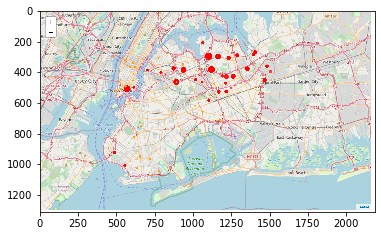

In [732]:
#show PNG if map does not render
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(r'C:\Users\samni\Documents\SAMs FOLDER\[0] 0 0 0 2 DATA SCIENCE\[0] COUSERA\16 Applied Data Science Capstone\capstone_asian_pop_density_map_nyc.png')
imgplot = plt.imshow(img)
plt.show()

__Review Dataframe of Asian Restaurant Counts across the 3 boroughs__

In [733]:
triboro_asian_resct2 = triboro_asian_rest.groupby(['Borough','Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']).size().reset_index(name='Asian Restaurant Count')
triboro_asian_resct2.sort_values("Asian Restaurant Count", inplace = True, ascending=False) 
triboro_asian_resct2.head()


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Asian Restaurant Count
69,Queens,Elmhurst,40.744049,-73.881656,48
90,Queens,Murray Hill,40.764126,-73.812763,25
37,Manhattan,Chinatown,40.715618,-73.994279,23
50,Manhattan,Midtown South,40.748510,-73.988713,19
88,Queens,Maspeth,40.725427,-73.896217,16


__Map Asian Restaurant Counts across the 3 boroughs__

In [734]:
triboro_asian_resct2['asian_rest_quartile'] = pd.qcut(triboro_asian_resct2['Asian Restaurant Count'], 4, duplicates='drop', labels=False)
nyc_asian_rest_map = folium.Map(location=[queens_lat, queens_long], zoom_start=11)
colordict = {0: 'green', 1: 'orange', 2: 'red', 3: 'blue'}

for lat, lon, neighborhood, quartile, asn_pop in zip(triboro_asian_resct2['Neighborhood Latitude'], 
                                triboro_asian_resct2['Neighborhood Longitude'], 
                                triboro_asian_resct2['Neighborhood'], 
                                #triboro_asian_resct2['Borough'],
                                triboro_asian_resct2['asian_rest_quartile'], triboro_asian_resct2['Asian Restaurant Count']):

    folium.CircleMarker(
        [lat, lon],
        radius=.35*asn_pop,
        popup = ('neighborhood: ' + str(neighborhood).capitalize() + '<br>'
                 'Asian Rest Count: ' + str(asn_pop) + '<br>'
                 #'Traffic level: ' + str(traffic) +'%'
                ),
        color='b',
        key_on = quartile,
        threshold_scale=[0,1,2,3],
        fill_color=colordict[quartile],
        fill=True,
        fill_opacity=0.7
        ).add_to(nyc_asian_rest_map)
nyc_asian_rest_map


Populating the interactive namespace from numpy and matplotlib


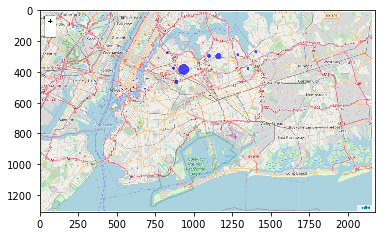

In [735]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(r'C:\Users\samni\Documents\SAMs FOLDER\[0] 0 0 0 2 DATA SCIENCE\[0] COUSERA\16 Applied Data Science Capstone\capstone_asian_rest_density_map_nyc.png')
imgplot = plt.imshow(img)
plt.show()

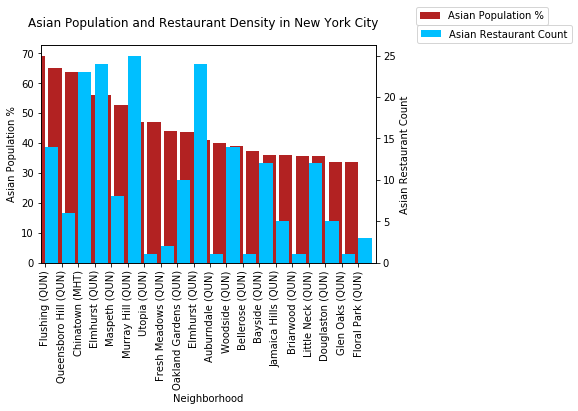

In [736]:
import matplotlib.pyplot as plt
fig = plt.figure() # Create matplotlib figure
fig.suptitle('Asian Population and Restaurant Density in New York City', fontsize=12)

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.8

triboro_viz.Asian_Pop.plot(kind='bar', color='firebrick', ax=ax, width=width, position=1, label='Asian Population %')
triboro_viz.Asian_Rest_Count.plot(kind='bar', color='deepskyblue', ax=ax2, width=width, position=0, label='Asian Restaurant Count')

ax.set_ylabel('Asian Population %')
ax2.set_ylabel('Asian Restaurant Count')
#plt.legend(bbox_to_anchor=(1.35, 1.0, 0.3, 0.2), loc='upper right')
ax.legend(bbox_to_anchor=(1.3, 1.0, 0.23, 0.2), loc='upper right')
ax2.legend(bbox_to_anchor=(1.3, 1.0, 0.3, 0.1), loc='center right')
plt.show()
#plt.savefig('capstone_pop_and_rest_density.png')

In [737]:

triboro_asnrest_pop_ratio = triboro_asian_rest_final
triboro_asnrest_pop_ratio['Rest_to_Pop_Ratio'] = (triboro_asnrest_pop_ratio['Asian_Rest_Count']/triboro_asnrest_pop_ratio['Asian_Pop']).round(2)
#triboro_asnrest_pop_ratio = triboro_asian_rest_final[['Neighborhood', 'Asian_Pop', 'Asian_Rest_Count', 'Rest_to_Pop_Ratio']]
triboro_asnrest_pop_ratio1 = triboro_asnrest_pop_ratio.sort_values(['Rest_to_Pop_Ratio'], ascending=[True])
#triboro_asnrest_pop_ratio1.drop(['Asian_Pop', 'Asian_Rest_Count'], axis=1, inplace=True)
asnrest_pop_ratio_viz = triboro_asnrest_pop_ratio1.head(20)
asnrest_pop_ratio_viz

,Asian_Pop,Asian_Rest_Count,Rest_to_Pop_Ratio
Neighborhood,,,
Auburndale (QUN),40.85,1,0.02
Utopia (QUN),47.05,1,0.02
Glen Oaks (QUN),33.57,1,0.03
Hillcrest (QUN),31.42,1,0.03
Briarwood (QUN),36.14,1,0.03
Bellerose (QUN),38.84,1,0.03
Pomonok (QUN),31.42,1,0.03
Fresh Meadows (QUN),47.05,2,0.04
Jamaica Estates (QUN),25.97,1,0.04


__Neighborhoods with low Asian restaurant to population ratio__

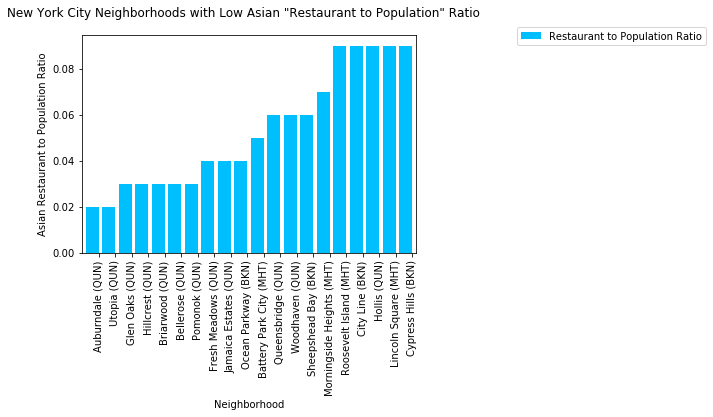

In [738]:
import matplotlib.pyplot as plt
fig = plt.figure() # Create matplotlib figure
fig.suptitle('New York City Neighborhoods with Low Asian "Restaurant to Population" Ratio', fontsize=12)

ax = fig.add_subplot(111) # Create matplotlib axes
width = 0.8
asnrest_pop_ratio_viz.Rest_to_Pop_Ratio.plot(kind='bar', color='deepskyblue', ax=ax, width=width, position=1, label='Restaurant to Population Ratio')
ax.set_ylabel('Asian Restaurant to Population Ratio')
ax.legend(bbox_to_anchor=(1.6, 1.0, 0.28, 0.06), loc='upper right')
plt.show()

## 6. Conclusion

Based on lower ratio of Asian restaurants Asian population, the top 10 neighborhoods for opening a Chinese restaurant in New York City are as follows:
1. Auburndale (QUN)
2. Utopia (QUN)
3. Glen Oaks (QUN)
4. Hillcrest (QUN)
5. Briarwood (QUN)
6. Bellerose (QUN)
7. Pomonok (QUN)
8. Fresh Meadows (QUN)
9. Jamaica Estates (QUN)
10. Ocean Parkway (BKN)

However, investors should consider other factors such as neighborhood security which are not accounted for in this project. On the other hand, it is possible that not all Chinese restaurants are listed on Foursquare. This was evident in Manhattan's Chinatown which has a very high Asian population but no fewer Asian restaurants on Foursquare. On the other hand, it was not easy to distinguish among Asian and Chinese restaurant categories, thereby making the assumption that higher Asian populations include Chinese people. Moreover, it is assumed that at non-Chinese Asian people will dine at a Chinese restaurant if there is no other Asian restaurant in the neighborhood. 